# General explanation of the process

1. Extract ROI
    - This is done by analyzing intensity of the image
2. Generate mask
3. Get a line from the mask

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.ndimage import gaussian_filter

# 1. Image load and get ROI (region of interest)

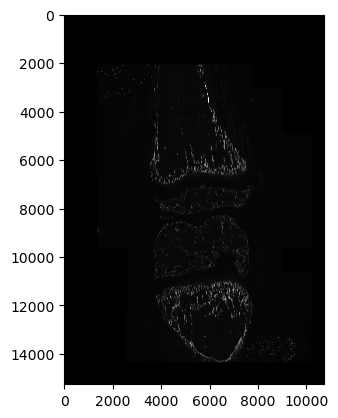

In [5]:
# Load an image
path2img = '/home/yec23006/projects/research/KneeGrowthPlate/Knee_GrowthPlate/Images/CCC_K05_hK_FL1_s1_1_shift3.jpg'
img = plt.imread(path2img)
plt.imshow(img, 'gray')
plt.show()

(15252, 10716)
(15252,)


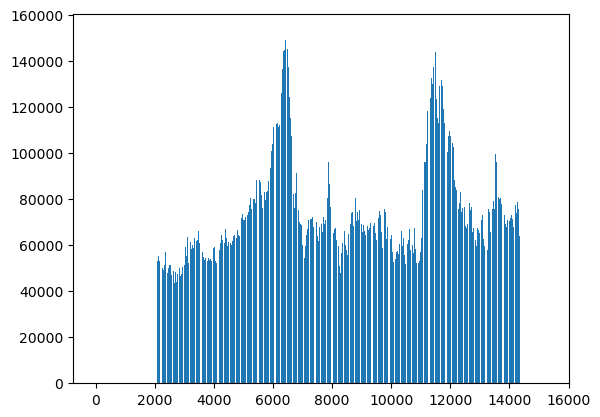

In [6]:
# Get intensity plot of the image for extracing RoI

imgArray = np.array(img)
print(imgArray.shape)

intensity = np.sum(imgArray, axis=1)
print(intensity.shape)

plt.bar(range(len(intensity)), intensity)
plt.show()

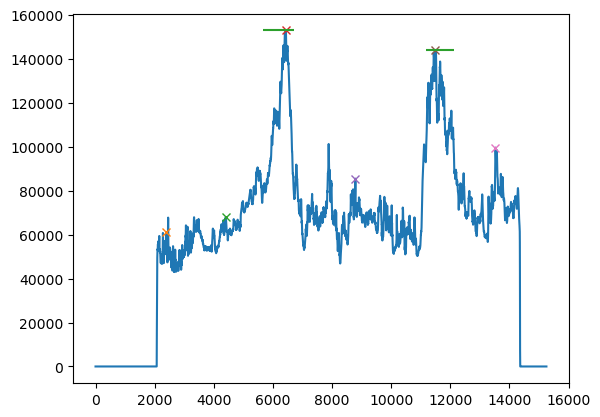

Peak 1 range: 5648 to 6716
Peak 2 range: 11175 to 12125


In [7]:
# Get the peaks

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
 
# Sample data: Replace with your dataset
x = range(len(intensity))
y = intensity
 
# Find peaks
peaks, _ = find_peaks(y, height=0, distance=2000)
 
# Calculate the widths of the peaks
results_full = peak_widths(y, peaks, rel_height=0.5)
 
# Extract widths and the x-positions of the peaks
widths = results_full[0]
left_ips = results_full[2]
right_ips = results_full[3]
 
# For the two main peaks, find their range
# If you specifically want to find only the two highest peaks:
ordered_peaks = sorted(peaks, key=lambda peak: y[peak], reverse=True)[:2]
ordered_widths = [widths[np.where(peaks == peak)[0][0]] for peak in ordered_peaks]
ordered_left_ips = [left_ips[np.where(peaks == peak)[0][0]] for peak in ordered_peaks]
ordered_right_ips = [right_ips[np.where(peaks == peak)[0][0]] for peak in ordered_peaks]
 
# Plot for visualization
plt.plot(x, y)
for peak in peaks:
    plt.plot(x[peak], y[peak], "x")
for i, peak in enumerate(ordered_peaks):
    plt.hlines(y[peak], x[int(ordered_left_ips[i])], x[int(ordered_right_ips[i])], color="C2")
plt.show()
 
# Print peak ranges
for i, peak in enumerate(ordered_peaks):
    print(f"Peak {i+1} range: {x[int(ordered_left_ips[i])]} to {x[int(ordered_right_ips[i])]}")

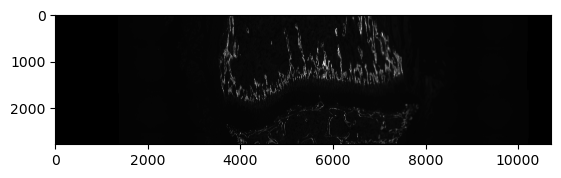

In [8]:
# Get the RoI
upper_bound = int(x[ordered_peaks[0]]*0.8)
lower_bound = x[ordered_peaks[0]]+1500#int((x[ordered_peaks[0]] + x[ordered_peaks[1]])*1/2)
img_section = img[upper_bound:lower_bound, :]
plt.imshow(img_section, 'gray')
plt.show()

# 2. Generate a mask

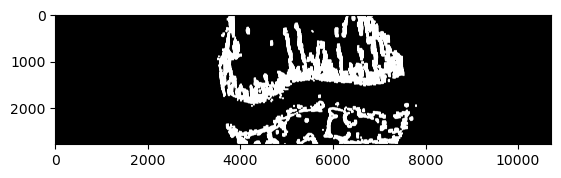

In [10]:
# Expand the thresholded image

blurred = cv2.GaussianBlur(img_section, (7,7), 0)

# Apply Sobel operator
sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=5)

# Compute the magnitude of the gradient
magnitude = cv2.magnitude(sobelx, sobely)

# Convert the magnitude to 8-bit image
magnitude = cv2.convertScaleAbs(magnitude)

# Threshold the image to get edges
threshold = 200  # You can adjust this threshold value
edges = cv2.threshold(magnitude, threshold, 255, cv2.THRESH_BINARY)[1]

kernel1 = np.ones((7,7), np.uint8)
kernel2 = np.ones((2,2), np.uint8)
dilated_image = cv2.dilate(edges, kernel1, iterations=7)
closed_img = cv2.erode(dilated_image, kernel2, iterations=7)

# Close the object
idx_img=sorted(np.where(closed_img==255)[1])
left_idx = idx_img[0]
right_idx = idx_img[-1]
closed_img[0, left_idx:right_idx] = 255

plt.figure()
plt.imshow(closed_img, 'gray')
plt.show()



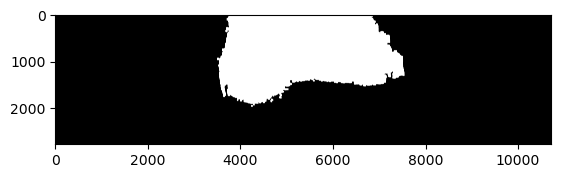

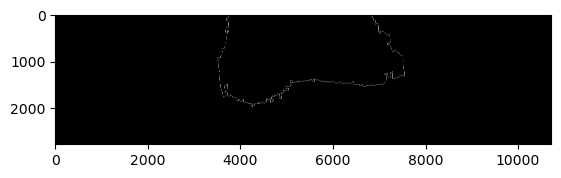

In [14]:
# Find contours
def getBordered(image, width):
    bg = np.zeros(image.shape)
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    biggest = 0
    bigcontour = None
    for contour in contours:
        area = cv2.contourArea(contour) 
        if area > biggest:
            biggest = area
            bigcontour = contour
    return cv2.drawContours(bg, [bigcontour], 0, (255, 255, 255), width).astype(bool) 

contours, _ = cv2.findContours(closed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Select the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Create a mask for the largest contour
largest_contour_mask = np.zeros_like(closed_img)
cv2.drawContours(largest_contour_mask, [largest_contour], -1, 255, -1)


# Display the result
plt.figure()
plt.imshow(largest_contour_mask, 'gray')


edge = getBordered(largest_contour_mask, 3)
plt.figure()
plt.imshow(edge, 'gray')
plt.show()

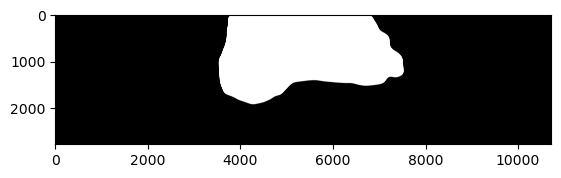

In [15]:
# Apply a gaussian filter
xscipy=gaussian_filter(largest_contour_mask, sigma=70, mode="wrap")
thres_xscipy = np.where(xscipy>255*0.5, 255, 0)
plt.imshow(thres_xscipy, 'gray')
plt.show()

# 3. Get the bottom line

possible pairs of x,y are gathered


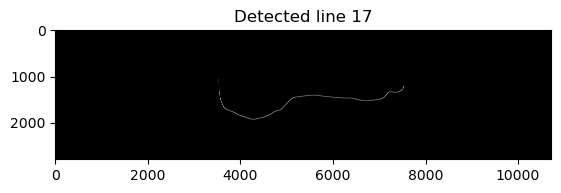

In [16]:
roi_idx_x, roi_idx_y = np.where(thres_xscipy==255)
unique_y = np.unique(roi_idx_y)
points_list = []
for y in unique_y:
    x_list = []
    overlapped_y_idx = np.where(np.array(roi_idx_y) ==y)[0]
    x_list = [roi_idx_x[i] for i in overlapped_y_idx]
    points_list.append([x_list, y])
print("possible pairs of x,y are gathered")
bottom_line_idx = []
for xy in points_list:
    pair = [max(xy[0]), xy[1]]
    bottom_line_idx.append(pair)

bottom_line = np.zeros(thres_xscipy.shape)
for i, j in bottom_line_idx:
    bottom_line[i,j] = 1

bottom_line_ = cv2.dilate(bottom_line, kernel=np.ones((7,7), np.uint8))
plt.imshow(bottom_line_, 'gray')
plt.title('Detected line 17')
plt.show()